In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, MaxPooling3D, Convolution2D, AveragePooling2D, MaxPooling2D, ZeroPadding3D, ZeroPadding2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import operator
from tqdm import tqdm_notebook as tqdm
import keras
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from scipy import stats
import pandas as pd
import numpy as np

from keras.models import model_from_json
import random
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
import matplotlib.pyplot as plt
import gc
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import confusion_matrix
from tools import *
# Models
from models_keras import CNNT5_3D, LeNet3d, VGG11_3D

## Load test set from one of the configurations

In [3]:
testset_config = 'D1'  # or 'D2'

val_non = pd.read_csv('/home.stud/dobkomar/data/val_data_0_{}.csv'.format(testset_config))
val_nod = pd.read_csv('/home.stud/dobkomar/data/val_data_1.csv')

candidates_val = pd.concat([val_non, val_nod])

In [4]:
# Load 3-D DATA

X_test, Y_test = [], []
val_mean, val_names = [], []

for row in tqdm(candidates_val.iterrows()):
    image = row[1]
    y_class = int(image['class'])
    lung_img = np.load(image['filename'])
    if lung_img.shape[0] == 32:
        X = lung_img.reshape((32, 32, 32))
        val_mean.append(np.mean(X))
        if np.mean(X) > 1:
            X_test.append(X.reshape((32, 32, 32, 1))), Y_test.append(y_class)
            val_names.append(image['filename'])


X_test, Y_test = np.array(X_test), np.array(Y_test)
Y_test = np_utils.to_categorical(Y_test, 2)

In [5]:
X_test.shape, Y_test.shape

((16706, 32, 32, 32, 1), (16706, 2))

In [6]:
# Range changing
# [-1, 1]
# X_test_range = X_test*np.std(X_test)+np.mean(X_test)
# [0, 1]
X_test_range = (X_test-np.mean(X_test))/np.std(X_test)

## Load a model with trained weights

In [7]:
model_name = 'cnnt53d_{}'.format(testset_config)

LOGS = '/home.stud/dobkomar/NoduleDetection/SubmitLogs/SubmitModels/'
json_file = open(LOGS+"{}.json".format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(LOGS+'{}.h5'.format(model_name))

Confusion matrix, without normalization
[[8440  300]
 [ 672 7294]]


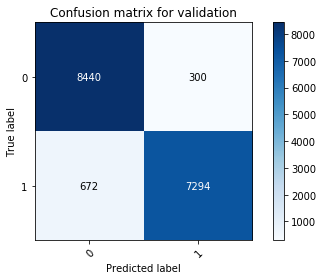

In [8]:
# Measure predictions
predicted = np.argmax(loaded_model.predict(X_test_range), axis=-1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(np.argmax(Y_test, axis=-1), predicted, title='Confusion matrix for validation')

In [9]:
recall_score(np.argmax(Y_test, axis=-1), predicted),accuracy_score(np.argmax(Y_test, axis=-1), predicted) 

(0.9156414762741653, 0.9418173111456961)